### we use the modified continuous cartpole env from openai gym of this link

https://gist.github.com/iandanforth/e3ffb67cf3623153e968f2afdfb01dc8

other useful link

https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#implementing-reward-to-go-policy-gradient

In [118]:
from env import ContinuousCartPoleEnv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

plt.rcParams['font.size']='14'

env=ContinuousCartPoleEnv()

/Users/wang-j/opt/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [2]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [3]:
env.action_space

Box([-1.], [1.], (1,), float32)

In [8]:
env.action_space.sample()

array([-0.45743683], dtype=float32)

In [212]:
np.random.seed(1)

def Gaussian_policy(theta_mu,theta_sig,s):
    
    mu=theta_mu.T.dot(s)[0]
    upper=theta_sig.T.dot(s)
    sig=np.exp(upper-np.max(upper))[0]
    
    return np.random.normal(mu,sig)[0],mu[0],sig[0]
    
def get_dlog(mu,sig,s,a):
    
    dlog_mu=((a-mu)/(sig**2))*s
    dlog_sig=(((a-mu)**2/sig**2)-1)*s
    
    return dlog_mu,dlog_sig

def get_return(rewards,gm):
    
    R=np.zeros(len(rewards))
    R[-1]=rewards[-1]
    for i in range(2,len(R)+1):
        R[-i]=gm*R[-i+1]+rewards[-i]
        
    return R

def run_reinforce(n_eps=5000,n_stps=1000,gm=0.99,lr=0.0001,baseline=False):
    
    theta_mu=np.zeros((4,1))
    theta_sig=np.zeros((4,1))

    r_all,s_all=[],[]
    for ep in range(n_eps):
        stp,r_sum,done=0,0,False
        states,actions,rewards,mus,sigs=[],[],[],[],[]
        s=env.reset().reshape((4,1))
        for stp in range(n_stps):

            a,mu,sig=Gaussian_policy(theta_mu,theta_sig,s)
            s_,r,done,_=env.step(a)
            s_=s_.reshape((4,1))

            states.append(s)
            actions.append(a)
            rewards.append(r)
            mus.append(mu)
            sigs.append(sig)

            s=s_
            stp+=1
            
            if done:
                break

        R=get_return(rewards,gm)
        
        #update policy parameters
        gmt=1
        for i in range(len(rewards)):
            dlog_mu,dlog_sig=get_dlog(mus[i],sigs[i],states[i],actions[i])
            if baseline:
                theta_mu=theta_mu+lr*gmt*(R[i]-sum(R)/len(R))*dlog_mu
                theta_sig=theta_sig+lr*gmt*(R[i]-sum(R)/len(R))*dlog_sig
            else:
                theta_mu=theta_mu+lr*gmt*(R[i])*dlog_mu
                theta_sig=theta_sig+lr*gmt*(R[i])*dlog_sig
            gmt*=gm

        #if ep%(n_eps//10)==0:
        #    print(f'ep:{ep}, R:{sum(rewards)}, stp:{stp}')

        r_all.append(sum(rewards))
        s_all.append(stp)

    return r_all,s_all

res={}
n_eps=5000
n_runs=10
baselines=[False,True]
labels=['REINFORCE','REINFORCE-baseline']

for i in range(len(labels)):
    for n in range(n_runs):
        print(n)
        r,s=run_reinforce(n_eps=n_eps,baseline=baselines[i])
        res[labels[i]+'_'+str(n)+'_return']=r
        res[labels[i]+'_'+str(n)+'_step']=s

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [213]:
res_df=pd.DataFrame.from_dict(res)
res_df

,REINFORCE_0_return,REINFORCE_0_step,REINFORCE_1_return,REINFORCE_1_step,REINFORCE_2_return,REINFORCE_2_step,REINFORCE_3_return,REINFORCE_3_step,REINFORCE_4_return,REINFORCE_4_step,...,REINFORCE-baseline_5_return,REINFORCE-baseline_5_step,REINFORCE-baseline_6_return,REINFORCE-baseline_6_step,REINFORCE-baseline_7_return,REINFORCE-baseline_7_step,REINFORCE-baseline_8_return,REINFORCE-baseline_8_step,REINFORCE-baseline_9_return,REINFORCE-baseline_9_step
0,20.0,20,24.0,24,7.0,7,6.0,6,31.0,31,...,32.0,32,8.0,8,6.0,6,8.0,8,7.0,7
1,40.0,40,5.0,5,14.0,14,21.0,21,20.0,20,...,7.0,7,6.0,6,15.0,15,13.0,13,11.0,11
2,10.0,10,7.0,7,5.0,5,14.0,14,12.0,12,...,12.0,12,10.0,10,7.0,7,18.0,18,36.0,36
3,9.0,9,15.0,15,6.0,6,14.0,14,15.0,15,...,5.0,5,11.0,11,7.0,7,15.0,15,10.0,10
4,14.0,14,31.0,31,15.0,15,17.0,17,17.0,17,...,20.0,20,34.0,34,7.0,7,7.0,7,13.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.0,7,1000.0,1000,580.0,580,689.0,689,9.0,9,...,145.0,145,552.0,552,251.0,251,542.0,542,203.0,203
4996,12.0,12,401.0,401,1000.0,1000,1000.0,1000,8.0,8,...,405.0,405,445.0,445,1000.0,1000,1000.0,1000,1000.0,1000
4997,6.0,6,1000.0,1000,440.0,440,552.0,552,6.0,6,...,175.0,175,651.0,651,1000.0,1000,1000.0,1000,392.0,392
4998,11.0,11,1000.0,1000,585.0,585,507.0,507,6.0,6,...,173.0,173,464.0,464,860.0,860,375.0,375,216.0,216


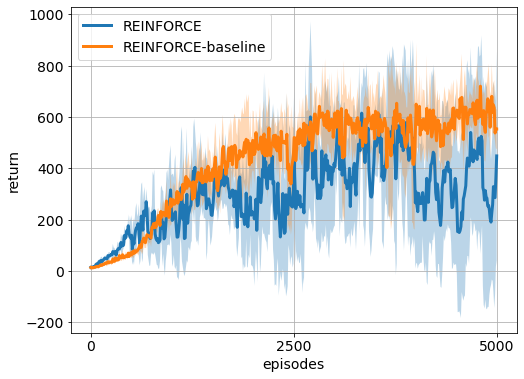

In [214]:
def plot_results_all(res,labels,n_runs=10,feature='return',length=5000,n_smooth=10):
    
    plt.figure(figsize=(8,6))
    
    for i in range(len(labels)):
        res_df=pd.DataFrame.from_dict(res)
        
        mean=res_df[[labels[i]+'_'+str(n)+'_'+feature for n in range(n_runs)]].groupby(np.arange(length)//n_smooth).mean().mean(axis=1)
        std=res_df[[labels[i]+'_'+str(n)+'_'+feature for n in range(n_runs)]].groupby(np.arange(length)//n_smooth).mean().std(axis=1)

        plt.plot(mean,label=labels[i],linewidth=3)
        plt.fill_between(range(len(mean)),mean.add(std),mean.subtract(std), alpha=.3)
        
        
    plt.grid()
    ticks=list(range(len(mean)))#500
    labels=[0,int(len(ticks)/2),len(ticks)-1]
    #print(labels)
    plt.xticks([ticks[i] for i in range(len(ticks)) if i in labels],[0,length//2,length])
    plt.xlabel('episodes')
    plt.ylabel(feature)
    
    plt.legend(loc='upper left')
    plt.savefig(feature+'_reinforce_compare_cartpole.png',dpi=350)
    
    
plot_results_all(res,labels,n_runs=5,feature='return',length=n_eps)


In [ ]:
#check variance convergence